In [39]:
%pip install --upgrade pip
%pip install pandas numpy openpyxl matplotlib seaborn
import pandas,numpy,os,re,datetime,random,itertools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Read excel files

In [40]:
def get_indice_name(file_name:str)->str:
    """Cette fonction permet d'obtenir le nom de l'indice 
    à partir du code de ce dernier
    """
    # Nous définissons les détails de chaque indice 
    # dans une liste de dictionnaires
    # Avec les clés : code et name
    indices = [
            {'code':'^FCHI','name':'CAC40'},
            {'code':'^GSPC','name':'S&P 500'},
            {'code':'^HSI','name':'Hang Seng'},
            {'code':'MSCI','name':'MSCI Emerging Markets'},
            ]
    
    # Nous parcourons la liste pour trouver 
    # le dictionnaire correspondant
    # à l'indice dont le code correspond à file_name (paramètre)
    for indice in indices:
        if indice['code'] in file_name:
            # Nous renvoyons le nom de l'indice correspondant
            # Lorsqu'il est trouvé dans la liste
            return indice['name']
    # Sinon nous renvoyons le file_name (paramètre)
    return file_name 


def load_data(directory:str)->dict:
    # Nous définissons un dictionnaire
    data = dict()
    # Nous lisons tous les fichiers présents dans le directory (paramètre)
    for file_path in os.listdir(directory):
        try:
            # Si MSCI alors le fichier est différent (séparateur ;)
            if "MSCI" in file_path:
                # Nous lisons le fichier dans un dataframe
                # En utilisant le séparateur ;
                df = pandas.read_csv(f'{directory}/{file_path}', sep=';') 
            else:
                # Nous lisons le fichier dans un dataframe
                # Avec les paramètres par défaut
                df = pandas.read_csv(f'{directory}/{file_path}')
            # Nous ajoutons le dataframe dans le dictionnaire
            data[get_indice_name(file_path)] = df
        except Exception as error:
            # S'il y a une erreur, nous affichons le message
            # Mais nous ne levons pas d'exception
            # Ceci permet de continuer le chargement
            print(error)
    # Nous renvoyons le dictionnaire avec toutes les données
    return data

In [41]:
data = load_data('./input')

.DS_Store
'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
MSCI_EM.csv
^FCHI.csv
^HSI.csv


In [42]:
print(data)

{'MSCI Emerging Markets':             Date    Close     Open     High      Low
0     05/26/2023   972.86   963.09   973.60   963.09
1     05/25/2023   964.01   970.42   973.38   962.53
2     05/24/2023   970.90   977.20   977.74   969.84
3     05/23/2023   978.60   983.84   985.86   977.19
4     05/22/2023   983.27   977.26   984.90   976.87
...          ...      ...      ...      ...      ...
2950  02/03/2012  1048.36  1043.92  1050.36  1039.83
2951  02/02/2012  1043.96  1032.93  1045.24  1032.87
2952  02/01/2012  1029.87  1018.01  1031.25  1014.52
2953  01/31/2012  1019.39  1007.23  1022.46  1006.48
2954  01/30/2012  1006.17  1018.59  1021.66  1001.98

[2955 rows x 5 columns], 'CAC40':             Date         Open         High          Low        Close  \
0     1990-03-01  1836.000000  1838.000000  1827.000000  1832.000000   
1     1990-03-02  1831.000000  1860.000000  1831.000000  1860.000000   
2     1990-03-05  1866.000000  1874.000000  1862.000000  1874.000000   
3     1990-03-0

# Clean the data

In [43]:
def clean_data(data:dict)->dict:
    # Nous définissons un nouveau dictionnaire
    new_dict = dict()
    # Nous parcourons les données
    for header,content in data.items():
        # Nous appliquonns le type DataFrame
        # au contenu, afin de prévenir les erreurs
        content = pandas.DataFrame(content)
        # Nous vérifions le format du champ date
        if re.match("^\d{2}/\d{2}/\d{2}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%y').strftime('%Y-%m-%d')
            )
        elif re.match("^\d{2}/\d{2}/\d{4}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yyyy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%Y').strftime('%Y-%m-%d')
            )


        for column_name in content.columns:
            # Si le nom de la colonne comporte Close ou Date
            if column_name.strip().upper() in ['CLOSE','DATE']:
                # Si la colonne est date
                if column_name.strip().upper() in ['DATE']:
                    # Nous trions les dates par ordre croissant
                    content = content.sort_values(column_name, ascending=True)
                    # Nous ajoutons en indices la colonne date
                    content = content.set_index(column_name)
                    # Nous convertissons le type en datetime
                    content.index = pandas.to_datetime(content.index)
                else:
                    # Nous enregistrons le nom de la colonne close
                    close_column = list(column_name)
        

        # Nous gardons uniquement la colonne close
        content = content.loc[:, close_column]
    
        # Nous supprimons les lignes vides
        content = content.dropna()

        new_dict[header] = content
    return new_dict

In [44]:
cleaned_data = clean_data(data)

# Compute statistics

In [45]:
def statistics(cleaned_data:dict)->dict:
    # Nous allons calculer le rendement annuel
    # prix de clôture du dernier jour de l'année divisé par
    # prix de clôture du premier jour de l'année)
    results = list()
    for header,df in cleaned_data.items():
        stats = list()
        first = True
        for index, row in df.iterrows():
            if first:
                first_day_price = row[0]
                year = index.year
                first = False
            # Si l'année change
            if index.year != year:
                # Nous calculons le rendement annuel
                stats.append({year:(last_day_price/first_day_price)-1})
                first_day_price = row[0]
                year = index.year
            last_day_price = row[0]        
        results.append({header:stats})
    return results


In [46]:
yearly_data = statistics(cleaned_data)

In [ ]:
print(yearly_data)

In [51]:
dataframes = pandas.DataFrame()
for header,yearly_return in yearly_data.items():
    xs = list()
    ys = list()
    for a in yearly_return:
        for y,x in a.items():
            ys.append(y)
            xs.append(x)
    dataframes[header]=pandas.DataFrame(xs,index=ys)

dataframes.to_excel('output.xlsx')

# Now we should construct portfolios

In [52]:
def generate_weights(indexes_number):
    # Define the number of indexes and the step value
    num_indexes = indexes_number
    step = 0.05

    # Define the range of percentages to generate
    min_percent = 0
    max_percent = 1
    percent_range = range(int(min_percent/step), int(max_percent/step) + 1)

    # Generate all combinations of percentages using itertools.product()
    weight_combinations = itertools.product(percent_range, repeat=num_indexes)

    return [list(round(w*step,2) for w in weights) for weights in weight_combinations if sum(weights)*step == 1.0]


In [53]:
merged_df = dataframes.dropna()

# keep only rows with index above 2012
merged_df = merged_df[merged_df.index >= 2012]

# Create a storage df
portfolios_df = pandas.DataFrame()

weights_list = generate_weights(len(merged_df.columns))
for i,weights in enumerate(weights_list):
    # TO calculate the return of the portfolio,
    # we can use the weight
    # but to calculate the risk, we have to use covariance matrix
    returns = numpy.array([merged_df[mean_column] for mean_column in merged_df.columns])
    cov_matrix = numpy.cov(returns)
    # Portfolio standard deviation
    portfolio_std = numpy.sqrt(numpy.dot(numpy.dot(weights, cov_matrix), weights))
    # Calculate portfolio return
    portfolio_return = numpy.mean(numpy.dot(returns.T, weights))
    composition = str()
    portfolio_df = pandas.DataFrame({'return':portfolio_return,'risk':portfolio_std},index=[i])
    for weight,title in zip(weights,merged_df.columns):
        portfolio_df[title]=f"{round(weight*100)}%"
    portfolios_df = pandas.concat([portfolios_df,portfolio_df])


# Display statistics about analyzed data

In [54]:
#merged_df.describe().round(2).to_excel('statistics.xlsx')

# Draw the correlation matrix for the data

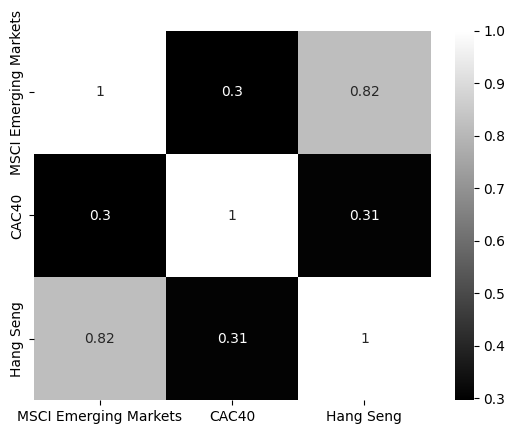

In [55]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = merged_df[merged_df.columns].corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='gray', annot=True)


# Save the heatmap to file
import matplotlib.pyplot as plt
plt.savefig('heatmap.png')

# Find most relevant portfolio

In [56]:
# Initialize excel writer to draw charts later
writer = pandas.ExcelWriter('portfolio.xlsx')
portfolios_df.to_excel(writer,sheet_name="portfolios",index=False)
# Get the index label of the portfolio with the lowest risk
min_risk_portfolio = portfolios_df['risk'].idxmin()

# Get the index label of the portfolio with the highest risk
max_risk_portfolio = portfolios_df['risk'].idxmax()

# Get the index label of the portfolio with the best Sharpe ratio
best_sharpe_portfolio = (portfolios_df['return']/portfolios_df['risk']).idxmax()

# Select the rows corresponding to the selected portfolios
selected_portfolios = portfolios_df.loc[[min_risk_portfolio, max_risk_portfolio, best_sharpe_portfolio]]
selected_portfolios.to_excel(writer,sheet_name="extremes",index=False)

writer.close()

In [57]:
sample = portfolios_df.sample(n=10, random_state=42)